# Student Test Scores challenge - Predicting scores on students
---

**Author**: [fsb2210](https://www.kaggle.com/fsb2210)

## Introduction

In this notebook we develop a linear predictive model, Ridge, in order to estimate test scores for different students using several different features such as demography, environment, behavior.

The dataset contains a mix of categorical and numerical features.

Import packages to be used throughout the notebook:

In [159]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

Define options:

In [160]:
# filenames
train_filename: str = "KaggleData/playground-series-s6e1/train.csv"
test_filename: str = "KaggleData/playground-series-s6e1/test.csv"

# split train dataset into train & valid subsets using this fraction
valid_split = 0.15

random_state: int = 42

# set random seed
np.random.seed(random_state)

## Data loading

Now we are able to load the training sample and split it between a training & validation subsets:

In [ ]:
train_df = pd.read_csv(train_filename)
test_df = pd.read_csv(test_filename)

ordinal_categories = {
    "sleep_quality": ["poor", "medium", "good"],
    "facility_rating": ["low", "medium", "high"],
    "exam_difficulty": ["easy", "moderate", "hard"]
}

quality_map = {"poor": 0, "medium": 1, "good": 2}
train_df['sleep_num'] = train_df['sleep_quality'].map(quality_map)
test_df['sleep_num'] = test_df['sleep_quality'].map(quality_map)

train_df['study_sleep_power'] = train_df['study_hours'] * train_df['sleep_num']
test_df['study_sleep_power'] = test_df['study_hours'] * test_df['sleep_num']

X = train_df.drop(["id", "exam_score"], axis=1)
y = train_df["exam_score"]

numerical_cols = ["age", "study_hours", "class_attendance", "sleep_hours","study_sleep_power"]
nominal_cols = ["gender", "course", "internet_access", "study_method"]
ordinal_cols = ["sleep_quality", "facility_rating", "exam_difficulty"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=valid_split, random_state=random_state,
)

In [187]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), numerical_cols),
        ("nominal", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), nominal_cols),
        ("ordinal", OrdinalEncoder(
            categories=[ordinal_categories[col] for col in ordinal_cols],
            handle_unknown="use_encoded_value",
            unknown_value=-1,  # for unseen categories assign this
        ), ordinal_cols)
    ],
    remainder="passthrough",
)

In [188]:
model = XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=6,
    early_stopping_rounds=50,
    random_state=random_state,
    n_jobs=-1,
    verbosity=0,
)

In [189]:
X_train_pre = preprocessor.fit_transform(X_train)
X_valid_pre = preprocessor.transform(X_valid)

model.fit(
    X_train_pre, y_train,
    eval_set=[(X_valid_pre, y_valid)],
    verbose=100
)

[0]	validation_0-rmse:18.71071
[100]	validation_0-rmse:11.37552
[200]	validation_0-rmse:9.58417
[300]	validation_0-rmse:9.10050
[400]	validation_0-rmse:8.93155
[500]	validation_0-rmse:8.85317
[600]	validation_0-rmse:8.82213
[700]	validation_0-rmse:8.80821
[800]	validation_0-rmse:8.80049
[900]	validation_0-rmse:8.79474
[1000]	validation_0-rmse:8.79005
[1100]	validation_0-rmse:8.78510
[1200]	validation_0-rmse:8.77970
[1300]	validation_0-rmse:8.77566
[1400]	validation_0-rmse:8.77204
[1500]	validation_0-rmse:8.76787
[1600]	validation_0-rmse:8.76438
[1700]	validation_0-rmse:8.76169
[1800]	validation_0-rmse:8.75889
[1900]	validation_0-rmse:8.75599
[2000]	validation_0-rmse:8.75396
[2100]	validation_0-rmse:8.75197
[2200]	validation_0-rmse:8.74997
[2300]	validation_0-rmse:8.74827
[2400]	validation_0-rmse:8.74681
[2500]	validation_0-rmse:8.74575
[2600]	validation_0-rmse:8.74461
[2700]	validation_0-rmse:8.74335
[2800]	validation_0-rmse:8.74208
[2900]	validation_0-rmse:8.74086
[3000]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [181]:
# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ## ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
#     ("model", model)
# ])
# pipeline.fit(
#     X_train, y_train,
#     model__eval_set=[(pipeline.named_steps['preprocessor'].transform(X_valid), y_valid)], 
#     model__verbose=100
#     )

In [182]:
def score_model(model, X, y):
    """Evaluate the trained model and returns a dictionary with eval metrics"""
    # make predictions
    y_pred = model.predict(X)
    # return metrics & predictions
    return {
        "mse": mean_squared_error(y, y_pred),
        "rmse": root_mean_squared_error(y, y_pred),
        "r2": r2_score(y, y_pred),
        "y_pred": y_pred,
    }

In [183]:
score = score_model(model, X_valid_pre, y_valid)
print(f"mean squared error (MSE): {score['mse']:.4f}")
print(f"root mean squared error (RMSE): {score['rmse']:.4f}")
print(f"R2: {score['r2']:.4f}")

mean squared error (MSE): 76.1659
root mean squared error (RMSE): 8.7273
R2: 0.7855


In [192]:
history = [
    {"date": "1/8", "feature": "XGBoost_BaseLine", "valid_rmse": 8.7289, "kaggle": 8.73108, "memo": "初提出"},
    {"date": "1/8", "feature": "study * sleep", "valid_rmse": 8.7226, "kaggle":None , "memo": "効果あり"},
    {"date": "1/8", "feature": "study_log_and_sq", "valid_rmse": 8.7225, "kaggle":None , "memo": "効果なし"},
        {"date": "1/8", "feature": "study*attendance", "valid_rmse": 8.7273, "kaggle":None , "memo": "わずかに悪化"}
]
display(pd.DataFrame(history))

,date,feature,valid_rmse,kaggle,memo
0,1/8,XGBoost_BaseLine,8.7289,8.73108,初提出
1,1/8,study * sleep,8.7226,NaN,効果あり
2,1/8,study_log_and_sq,8.7225,NaN,効果なし
3,1/8,study*attendance,8.7273,NaN,わずかに悪化


Visualize predictions and compare them to ground truth:

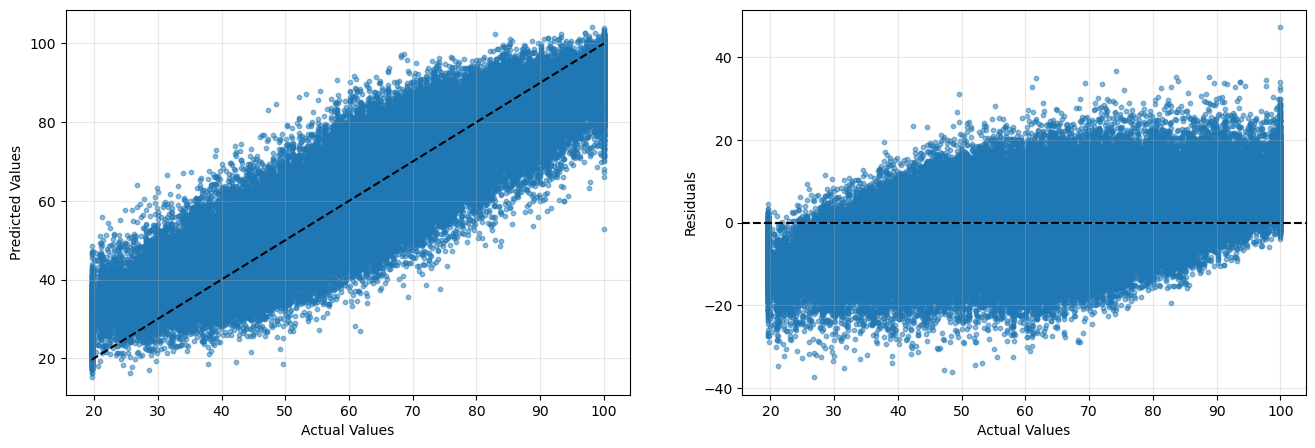

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

y_pred = score["y_pred"]

# 1. Actual vs Predicted
axes[0].scatter(y_valid, y_pred, alpha=0.5, s=10)
axes[0].plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], color="black", linestyle="--")
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted
residuals = y_valid - y_pred
axes[1].scatter(y_valid, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color="black", linestyle="--")
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, alpha=0.3)

There is a lot of spread around the dashed line representing a "perfect" match with the ground truth. Also something is happening at the boundaries...

First model to try and it doesn't seem to be a good fit! :-/

## Inference

We can finally make predictions on the test set and use them to submit a file to the competition:

In [171]:
test_df.head(n=2)

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,sleep_num,study_sleep_power,study_hours_log,study_hours_sq
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy,0.0,0.0,2.060514,46.9225
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy,0.0,0.0,2.029463,43.6921


Make predictions on test set, the pipeline takes care of encode and scale values in each of the corresponding columns:

In [172]:
X_test_pre = preprocessor.transform(test_df)
preds = model.predict(X_test_pre)

### Submission


Create DataFrame and submit file to competition:

In [173]:
sub_df = pd.DataFrame({"id": test_df.id, "exam_score": preds})
sub_df.to_csv("submission.csv", index=False)
sub_df.head(n=2)

,id,exam_score
0,630000,70.488556
1,630001,70.140701


In [174]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# パイプラインを使っている場合、最後のステップ（model）を取り出す
model = pipeline.named_steps['model']
plot_importance(model, max_num_features=10) # 上位10個を表示
plt.show()

NotFittedError: need to call fit or load_model beforehand

In [ ]:
# 前処理（ColumnTransformer）から、変換後の列名を取得する
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# 重要度のデータと列名を紐付ける
import pandas as pd
import matplotlib.pyplot as plt

# モデルから重要度を取り出す
importances = pipeline.named_steps['model'].feature_importances_

# 見やすいグラフにする
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("どのデータが予測に効いているか（名前付き）")
plt.show()

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Validデータでの予測値と実測値の差を計算
X_valid['actual'] = y_valid
X_valid['predict'] = pipeline.predict(X_valid)
X_valid['error'] = abs(X_valid['actual'] - X_valid['predict'])

# 誤差が大きい順に並べて表示
print(X_valid.sort_values('error', ascending=False).head(5))

        age  gender   course  study_hours  class_attendance internet_access  \
553891   21   other  diploma         1.73              73.6              no   
629254   17   other   b.tech         6.10              54.5             yes   
288783   24  female      bba         1.49              41.9             yes   
450474   18    male       ba         6.03              91.9             yes   
479255   24  female      bba         0.08              43.6             yes   

        sleep_hours sleep_quality study_method facility_rating  \
553891          7.5          good        mixed             low   
629254          6.3          poor   self-study            high   
288783          6.8          poor  group study          medium   
450474          9.1       average     coaching             low   
479255          6.2          good        mixed            high   

       exam_difficulty  actual    predict      error  
553891            easy   100.0  53.073162  46.926838  
629254            

「ターゲット・エンコーディング」を試してみる： 「学校名」や「出身地」のような、種類が多い文字データを、単なる数字（1, 2, 3...）ではなく、**「そのグループの平均点」**に置き換える手法です。これはXGBoostと非常に相性が良く、劇的に効くことがあります。
特徴量エンジニアリング（一番効く！）

例えば「試験科目ごとの合計」や「去年の成績との差」など、新しい列を作ってみる。
「特定の科目が0点の人」など、異常なパターンにフラグを立ててみる。
特徴量の重要度（Feature Importance）を確認

さっき話した plot_importance を実行して、「実はこの列、全然使われてないな」というものを探す。
他のモデルとのアンサンブル

XGBoostだけでなく、LightGBMやRandomForestの結果を「平均」してみる（これでスコアが0.01刻みで上がることがよくあります）。

1. 「エース変数」をさらに磨く（非線形な関係を作る）

グラフでダントツの study_hours ですが、XGBoostは「10時間と11時間の差」と「100時間と101時間の差」を同じように扱うのが少し苦手な場合があります。

二乗してみる: study_hours の2乗の列を追加する。

ログをとる: log(study_hours + 1) という列を作る。 これにより、勉強時間が増えるほどスコアへの影響が変化する（例：ある程度いくと伸び悩む、など）という現実的なパターンをモデルが掴みやすくなります。

3. 「死んでいる変数」を整理する

グラフの一番上、nominal__course_b.sc はほとんど予測に貢献していません。

いっそ消す: 全く使われていない列を削除すると、モデルが余計なノイズに惑わされなくなり、結果的にスコアが上がることがあります。

まとめる: 「B.Sc（理学士）」とか細かいコース名で効いていないなら、「理系・文系」というもっと大きな枠組みに作り直してみるのも手です。

「施設の評価 ÷ 学費」

「24時間 - 睡眠時間 = 活動時間（起きている時間）」

この活動時間のうち、**「どれくらいを勉強に充てたか（勉強の比率）」**が重要かもしれません。

「活動時間 - 勉強時間 = 自由時間（リラックス時間）」

勉強ばかりしてリラックス（自由時間）が全くない人は、逆に効率が落ちてスコアが低い…といった「人間らしいパターン」をモデルが探せるようになります。